<h2 st<h2 style='color:blue'>Retinal Image Analysis for Diabetic Retinopathy</h2>

<h3 st<h3 style='color:red'>Analysis using Deep Learning</h3>

<i>Dataset is taken from kaggle (Aptos 2019 Blindness Detection Dataset) 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

<h4 st<h4 style='color:purple'>Loading the dataset and Initial Image Preprocessing</h4>

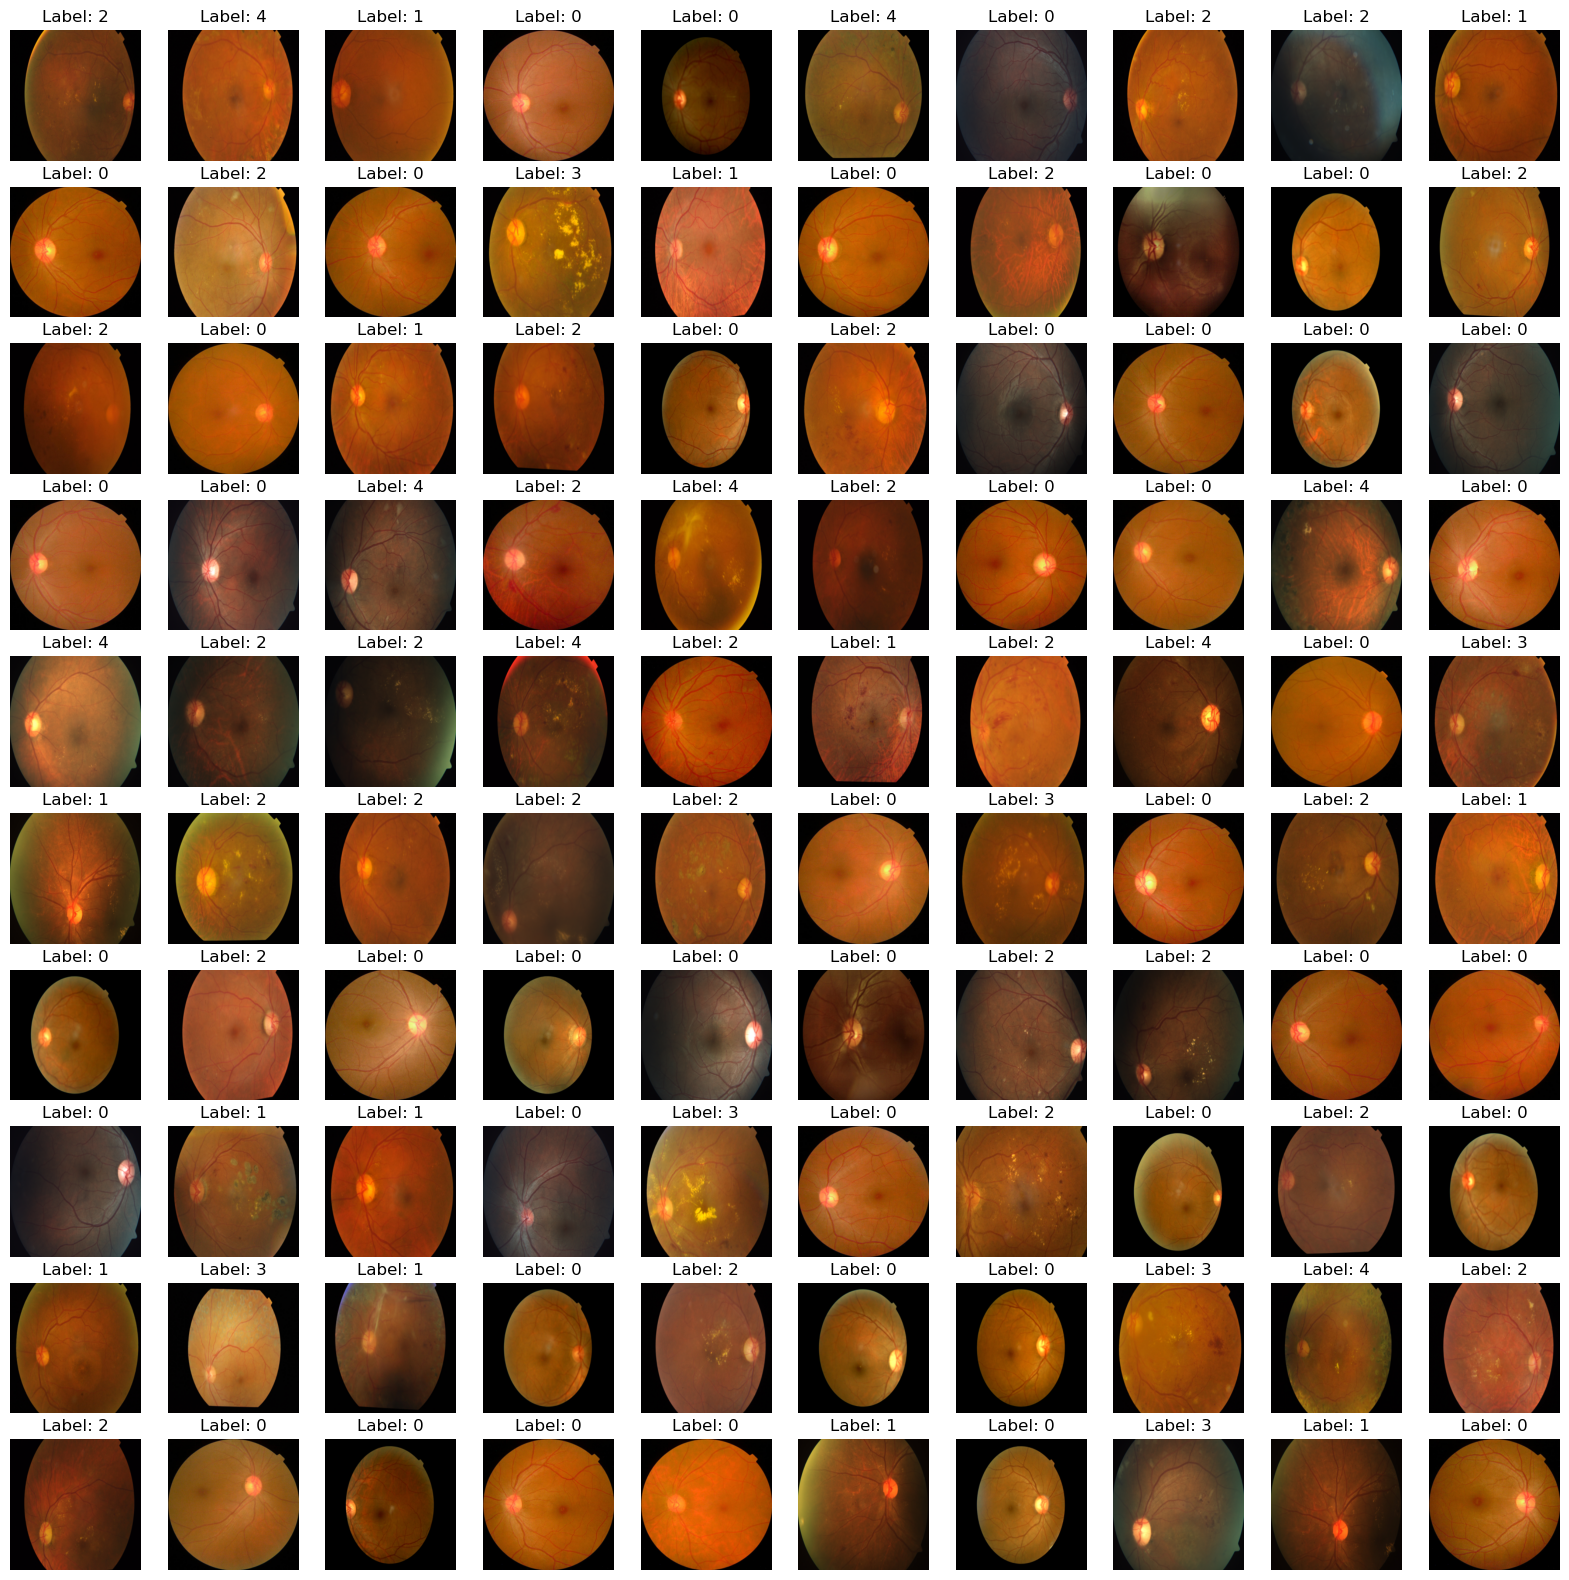

In [2]:
# Load Train Dataset
train_df = pd.read_csv("train.csv")
train_images_path = "train_images/"
train_images = []
# Load and preprocess train images
for image_name in train_df['id_code']:
    image_path = os.path.join(train_images_path, image_name + ".png")
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    train_images.append(np.array(image))
# Display first 100 images after loading
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_images[i])
    plt.title('Label: {}'.format(train_df['diagnosis'][i]))
    plt.axis('off')
plt.show()

<h4 st<h4 style='color:purple'>Improved Image Preprocessing using CLAHE</h4>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2

# Load Train Dataset
train_df = pd.read_csv("train.csv")
train_images_path = "train_images/"

# Preprocessing functions
def clahe(image, clip_limit=5.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to the image."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    clahe_image = cv2.merge(clahe_channels)
    return clahe_image

def adjust_brightness_contrast(image, brightness=30, contrast=50):
    """Adjust the brightness and contrast of an image."""
    image = np.int16(image)
    image = image * (contrast/127+1) - contrast + brightness
    image = np.clip(image, 0, 255)
    image = np.uint8(image)
    return image

# Preprocess train images with CLAHE, brightness, and contrast adjustment
preprocessed_images = []
for image_name in train_df['id_code']:
    image_path = os.path.join(train_images_path, image_name + ".png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    
    # Apply preprocessing
    clahe_image = clahe(image)
    enhanced_image = adjust_brightness_contrast(clahe_image)
    
    preprocessed_images.append(np.array(enhanced_image))

preprocessed_images = np.array(preprocessed_images)
preprocessed_images = preprocessed_images / 255.0

train_labels = train_df['diagnosis']

# Convert the labels to a numpy array
train_labels = np.array(train_labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

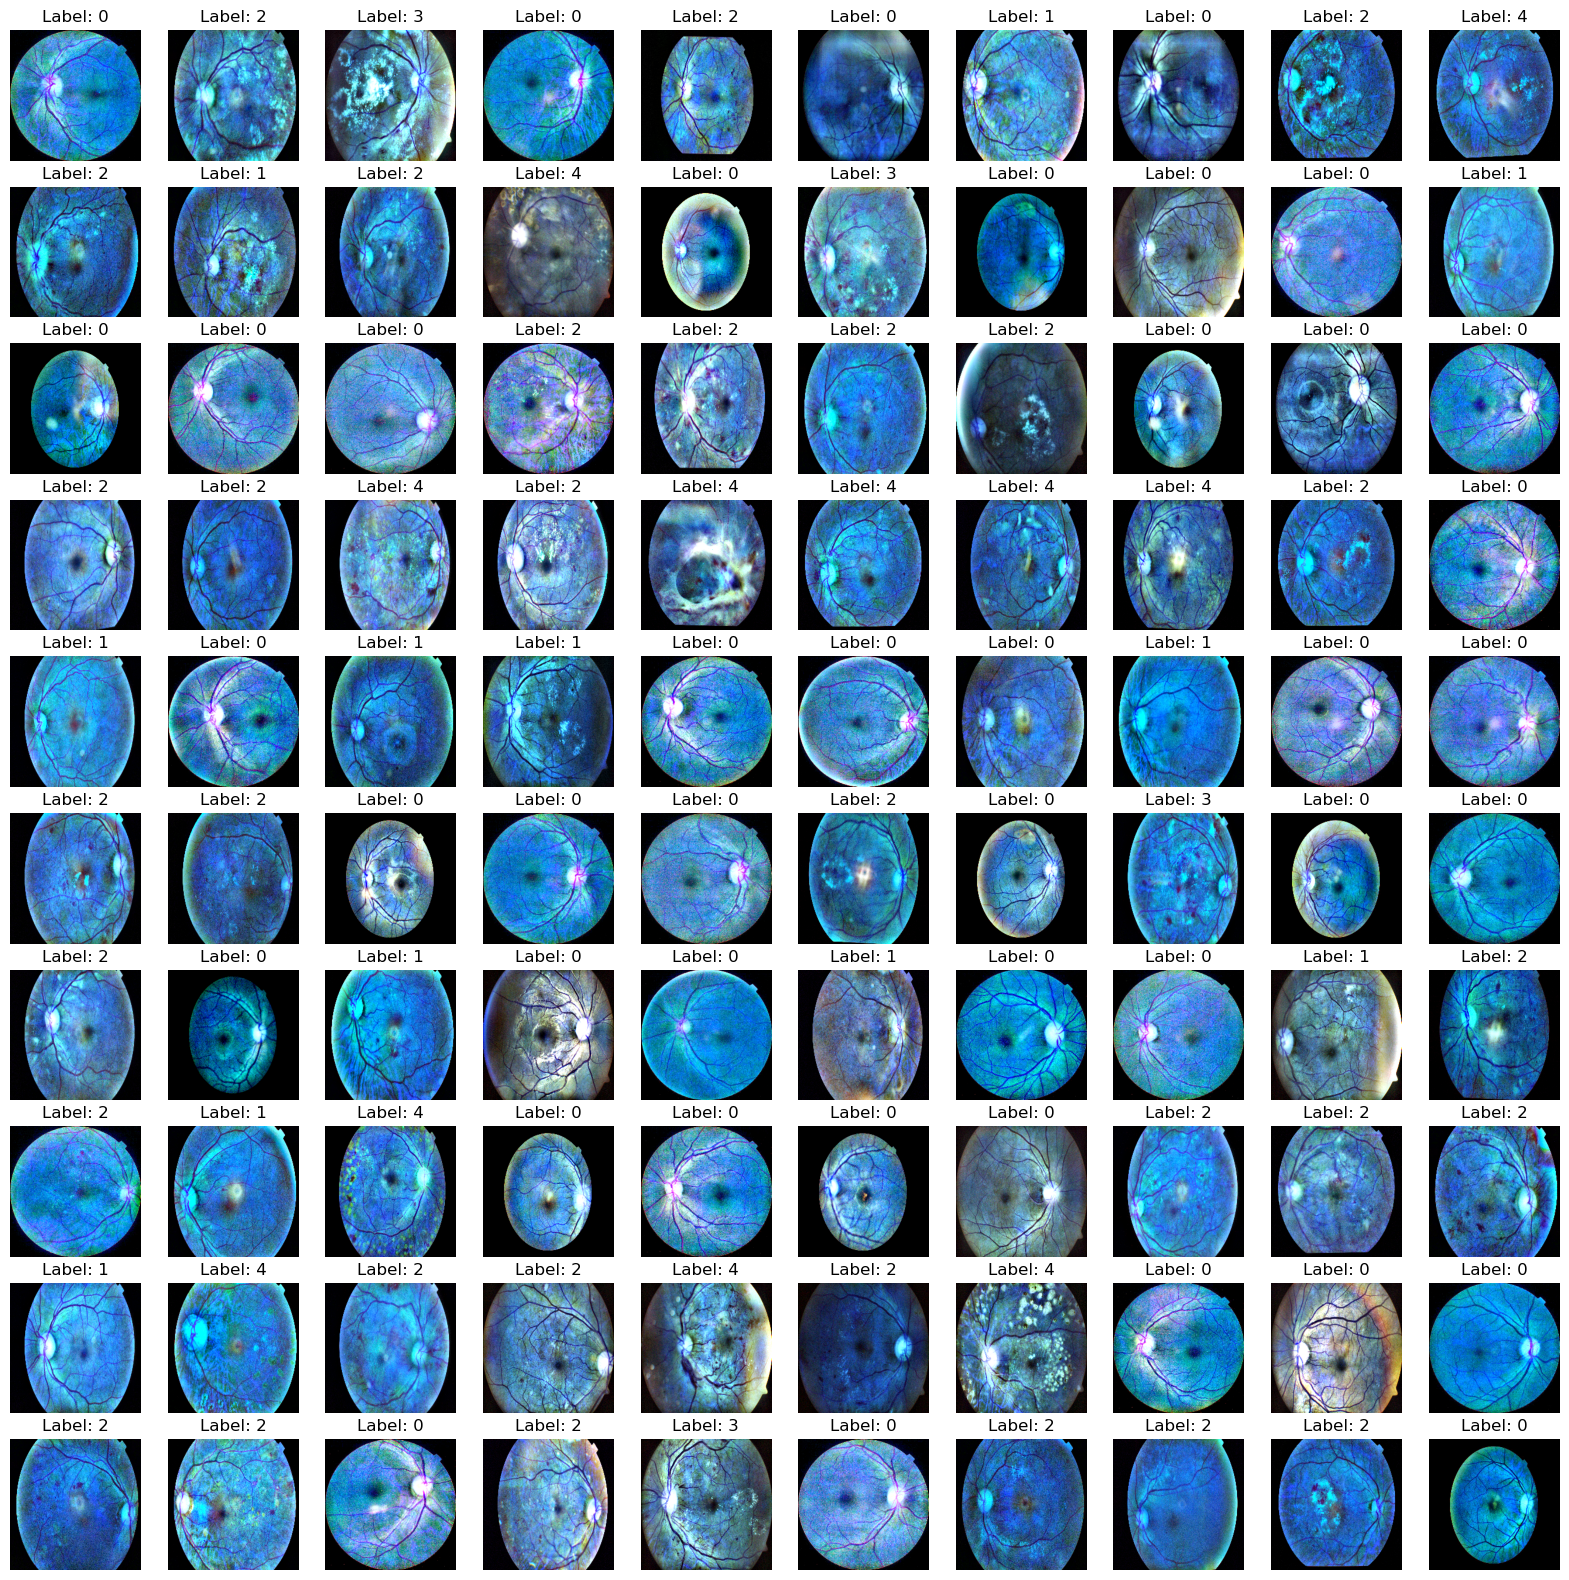

In [2]:
# Display first 100 images after loading
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_train[i])
    plt.title('Label: {}'.format(y_train[i]))
    plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [5]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

<h3 st<h3 style='color:purple'>DenseNet121 model training</h3>

In [6]:
# Load DenseNet121 without the top classification layer
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in densenet_model.layers:
    layer.trainable = False

# Create a Sequential model with the DenseNet base
densenet_hybrid_model = Sequential([
    densenet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model
densenet_hybrid_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model
history_densenet = densenet_hybrid_model.fit(X_train, y_train,
                                             validation_data=(X_val, y_val),
                                             epochs=20,
                                             batch_size=32,
                                             callbacks=[reduce_lr, early_stopping])


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.5578 - loss: 1.2769 - val_accuracy: 0.7231 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.7281 - loss: 0.7119 - val_accuracy: 0.7462 - val_loss: 0.7267 - learning_rate: 0.0010
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - accuracy: 0.7408 - loss: 0.6897 - val_accuracy: 0.7394 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.7536 - loss: 0.6347 - val_accuracy: 0.7503 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - accuracy: 0.7637 - loss: 0.6134 - val_accuracy: 0.7599 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.7698 - loss: 0.6105 - val_accuracy: 0.7722 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.7635 - loss: 0.6080 - val_acc

In [7]:
# Save the model
densenet_hybrid_model.save('densenet_clahe_model.h5')

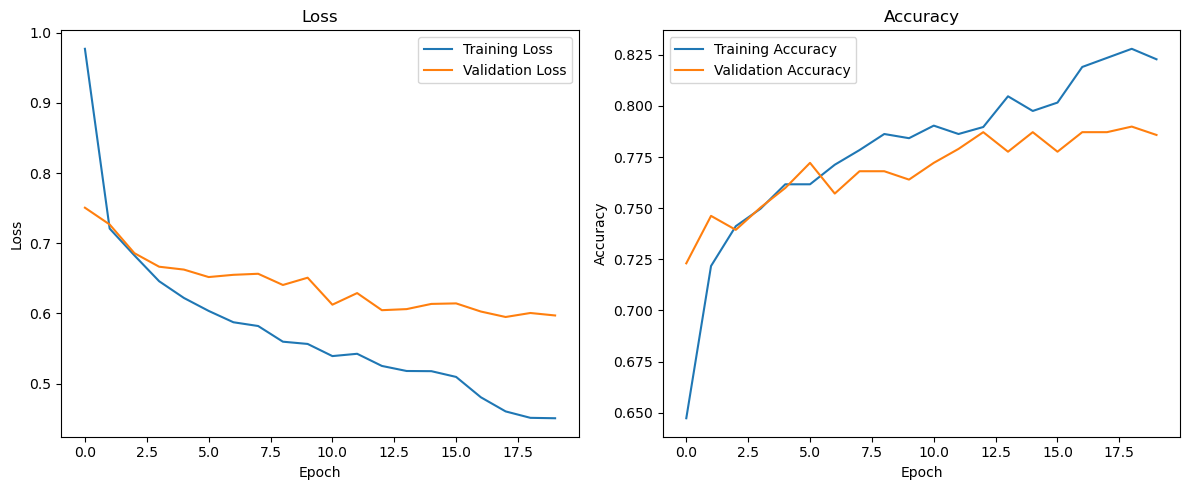

In [8]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
# Append results
results = []
def append_results(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    results.append((model_name, accuracy, precision, f1, recall))

In [9]:
# Evaluate and display results
y_pred = densenet_hybrid_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step


In [13]:
append_results('DenseNet121', y_val, y_pred_classes)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
results_df.set_index('Model', inplace=True)

In [14]:
results_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                         
DenseNet121  0.787176       0.771543      0.769445    0.787176

In [15]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, zero_division=0.0))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       361
           1       0.55      0.39      0.46        74
           2       0.66      0.86      0.75       200
           3       0.47      0.21      0.29        39
           4       0.54      0.32      0.40        59

    accuracy                           0.79       733
   macro avg       0.63      0.55      0.57       733
weighted avg       0.77      0.79      0.77       733



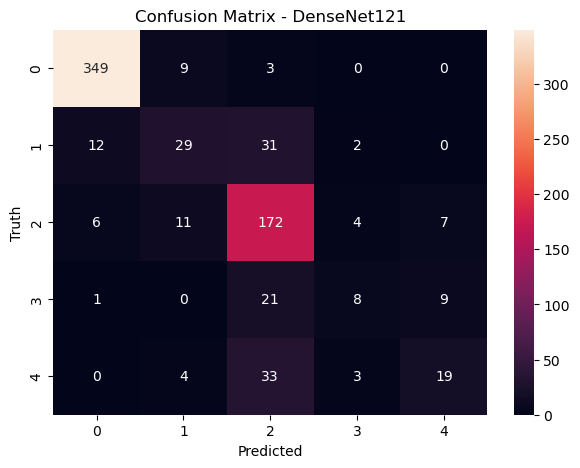

In [16]:
# Display confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - DenseNet121')
plt.show()

<h3 st<h3 style='color:purple'>ResNet50 model training</h3>

In [8]:
# Load ResNet50 without the top classification layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

# Create a Sequential model with the ResNet base
resnet_hybrid_model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model
resnet_hybrid_model.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

# Train the model
history_resnet = resnet_hybrid_model.fit(X_train, y_train,
                                         validation_data=(X_val, y_val),
                                         epochs=20,
                                         batch_size=32,
                                         )


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.4941 - loss: 1.4093 - val_accuracy: 0.6467 - val_loss: 1.0034
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.6564 - loss: 1.0181 - val_accuracy: 0.6821 - val_loss: 0.9257
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.6473 - loss: 0.9845 - val_accuracy: 0.6903 - val_loss: 0.8964
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 528s 6s/step - accuracy: 0.6600 - loss: 0.9430 - val_accuracy: 0.6767 - val_loss: 0.9003
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 464s 5s/step - accuracy: 0.6734 - loss: 0.9197 - val_accuracy: 0.6971 - val_loss: 0.8735
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.6657 - loss: 0.9062 - val_accuracy: 0.6903 - val_loss: 0.8632
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.6790 - loss: 0.8979 - val_accuracy: 0.6917 - val_loss: 0.8672
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.6721 - loss: 0.9005 - val_accuracy: 0.6889 - v

In [9]:
# Save the model
resnet_hybrid_model.save('resnet_clahe_model1.h5')

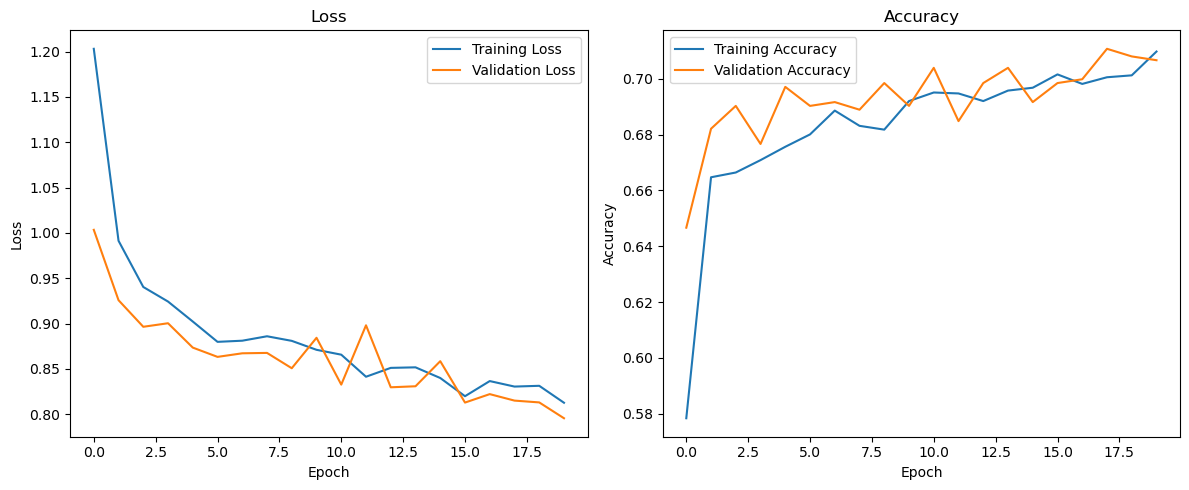

In [10]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Evaluate and display results
y_pred = resnet_hybrid_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step


In [14]:
append_results('ResNet50', y_val, y_pred_classes)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
results_df.set_index('Model', inplace=True)

In [15]:
results_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                      
ResNet50  0.706685       0.602943      0.630552    0.706685

In [16]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, zero_division=0.0))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.90       361
           1       0.29      0.03      0.05        74
           2       0.52      0.89      0.66       200
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        59

    accuracy                           0.71       733
   macro avg       0.34      0.37      0.32       733
weighted avg       0.60      0.71      0.63       733



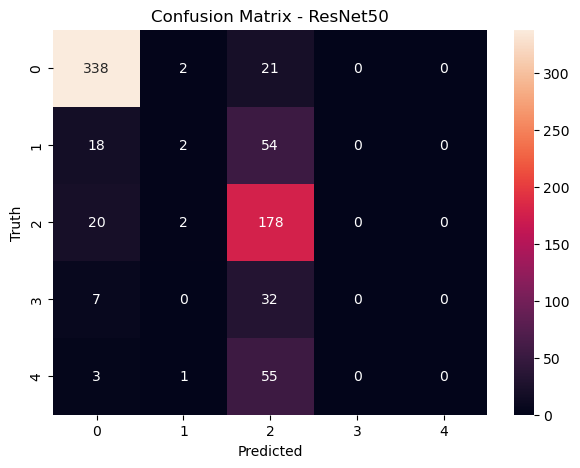

In [17]:
# Display confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - ResNet50')
plt.show()

<h3 st<h3 style='color:purple'>InceptionV3 model training</h3>

In [53]:
# Load InceptionV3 without the top classification layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in inception_model.layers:
    layer.trainable = False

# Create a Sequential model with the Inception base
inception_hybrid_model = Sequential([
    inception_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model
inception_hybrid_model.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])

# Train the model
history_inception = inception_hybrid_model.fit(X_train, y_train,
                                               validation_data=(X_val, y_val),
                                               epochs=20,
                                               batch_size=32)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.5478 - loss: 1.4259 - val_accuracy: 0.7080 - val_loss: 0.8019
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.7026 - loss: 0.8104 - val_accuracy: 0.7108 - val_loss: 0.7403
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.7280 - loss: 0.7326 - val_accuracy: 0.7203 - val_loss: 0.7365
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.7171 - loss: 0.7397 - val_accuracy: 0.7244 - val_loss: 0.7250
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.7337 - loss: 0.6935 - val_accuracy: 0.7353 - val_loss: 0.7372
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.7411 - loss: 0.6861 - val_accuracy: 0.7340 - val_loss: 0.7397
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7231 - loss: 0.7075 - val_accuracy: 0.7326 - val_loss: 0.7237
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.7425 - loss: 0.6742 - val_accuracy: 0.7299 - v

In [54]:
# Save the model
inception_hybrid_model.save('inception_clahe_model.h5')

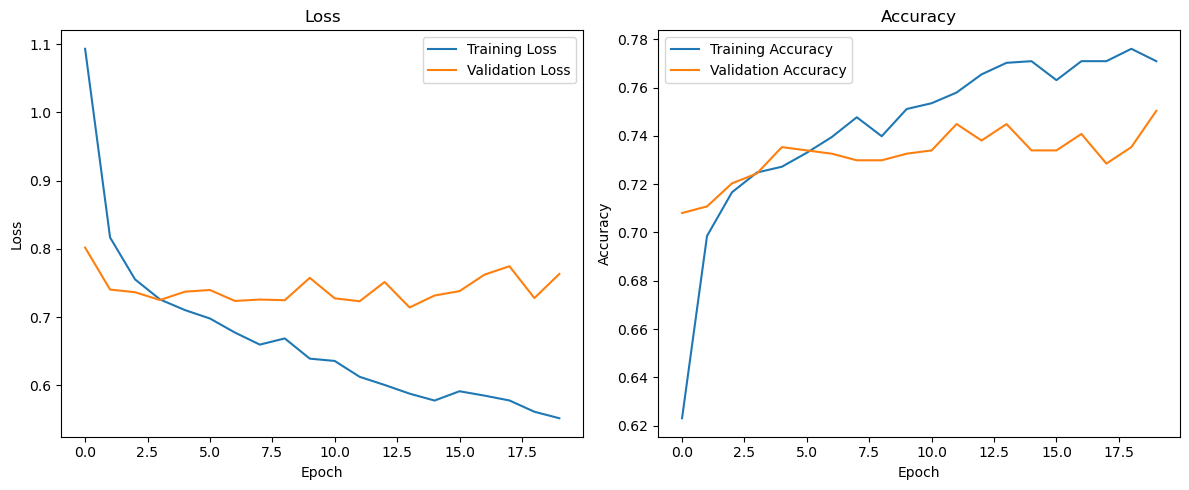

In [55]:

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Evaluate and display results
y_pred = inception_hybrid_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step


In [60]:
append_results('InceptionV3', y_val, y_pred_classes)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
results_df.set_index('Model', inplace=True)

In [61]:
results_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                         
DenseNet121  0.787176       0.771543      0.769445    0.787176
InceptionV3  0.750341       0.734632      0.693888    0.750341

<h3 st<h3 style='color:purple'>VGG16 model training</h3>

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

# Load VGG16 without the top classification layer
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in vgg16_model.layers:
    layer.trainable = False

# Create a Sequential model with the VGG16 base
vgg16_hybrid_model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model
vgg16_hybrid_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# Train the model
history_vgg16 = vgg16_hybrid_model.fit(X_train, y_train,
                                       validation_data=(X_val, y_val),
                                       epochs=20,
                                       batch_size=32,
                                       )


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1286s 14s/step - accuracy: 0.5036 - loss: 1.2985 - val_accuracy: 0.7108 - val_loss: 0.8679
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1208s 13s/step - accuracy: 0.7085 - loss: 0.8559 - val_accuracy: 0.7271 - val_loss: 0.7892
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1189s 13s/step - accuracy: 0.7147 - loss: 0.7907 - val_accuracy: 0.7244 - val_loss: 0.7604
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1147s 12s/step - accuracy: 0.7215 - loss: 0.7541 - val_accuracy: 0.7340 - val_loss: 0.7278
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1152s 13s/step - accuracy: 0.7323 - loss: 0.7137 - val_accuracy: 0.7258 - val_loss: 0.7191
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1268s 14s/step - accuracy: 0.7325 - loss: 0.6988 - val_accuracy: 0.7271 - val_loss: 0.7029
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1266s 14s/step - accuracy: 0.7324 - loss: 0.6907 - val_accuracy: 0.7312 - val_loss: 0.7106
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1189s 13s/step - accuracy: 0.7624 - loss: 0.6582 - val_accu

In [19]:
# Save the model
vgg16_hybrid_model.save('vgg16_clahe_model.h5')

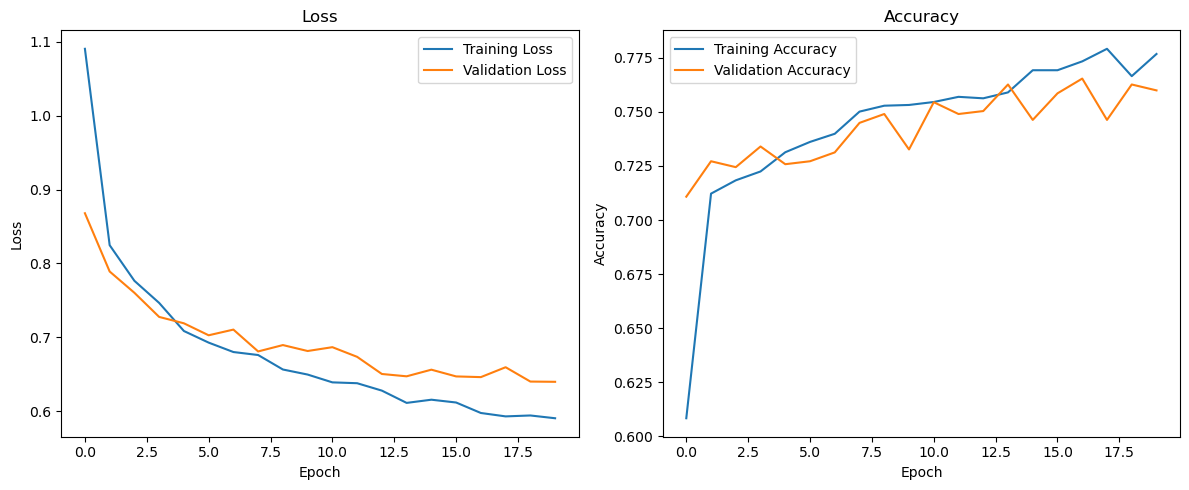

In [20]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluate and display results
y_pred = vgg16_hybrid_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
append_results('vgg16', y_val, y_pred_classes)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
results_df.set_index('Model', inplace=True)

23/23 ━━━━━━━━━━━━━━━━━━━━ 348s 15s/step


In [22]:
results_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                      
ResNet50  0.706685       0.602943      0.630552    0.706685
vgg16     0.759891       0.747372      0.740880    0.759891

In [23]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, zero_division=0.0))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       361
           1       0.45      0.46      0.46        74
           2       0.63      0.80      0.71       200
           3       0.64      0.18      0.28        39
           4       0.41      0.19      0.26        59

    accuracy                           0.76       733
   macro avg       0.61      0.52      0.53       733
weighted avg       0.75      0.76      0.74       733



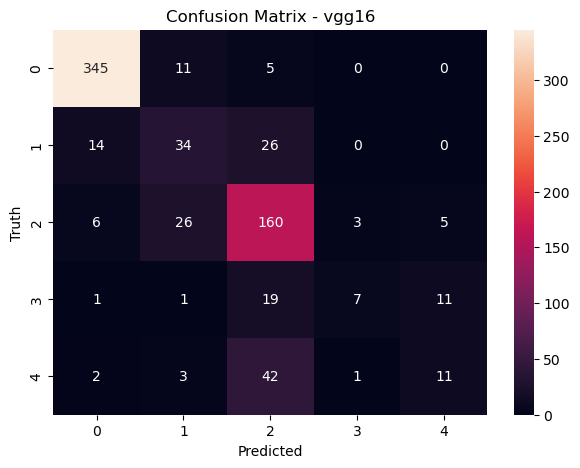

In [24]:
# Display confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - vgg16')
plt.show()

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2

# Load Train Dataset
train_df = pd.read_csv("train.csv")
train_images_path = "train_images/"

# Preprocessing functions
def clahe(image, clip_limit=5.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to the image."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    clahe_image = cv2.merge(clahe_channels)
    return clahe_image

def adjust_brightness_contrast(image, brightness=30, contrast=50):
    """Adjust the brightness and contrast of an image."""
    image = np.int16(image)
    image = image * (contrast/127+1) - contrast + brightness
    image = np.clip(image, 0, 255)
    image = np.uint8(image)
    return image

# Preprocess train images with CLAHE, brightness, and contrast adjustment
preprocessed_images = []
for image_name in train_df['id_code']:
    image_path = os.path.join(train_images_path, image_name + ".png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    
    # Apply preprocessing
    clahe_image = clahe(image)
    enhanced_image = adjust_brightness_contrast(clahe_image)
    
    preprocessed_images.append(np.array(enhanced_image))

preprocessed_images = np.array(preprocessed_images)
preprocessed_images = preprocessed_images / 255.0

train_labels = train_df['diagnosis']

# Convert the labels to a numpy array
train_labels = np.array(train_labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, train_labels, test_size=0.2 ,stratify=train_labels)



<h3 st<h3 style='color:purple'>EfficientNetB0 model training</h3>

In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback


# Load EfficientNetB0 without the top classification layer
efficientnetb0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers of the model
for layer in efficientnetb0_model.layers[-20:]:
    layer.trainable = True

# Create a Sequential model with the EfficientNetB0 base
efficientnetb0_hybrid_model = Sequential([
    efficientnetb0_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model
efficientnetb0_hybrid_model.compile(optimizer=Adam(),
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy'])

# Instantiate the callbacks
print_summary_callback = PrintSummaryCallback()


# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with data augmentation and callbacks
history_efficientnetb0 = efficientnetb0_hybrid_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20
)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 899s 9s/step - accuracy: 0.4298 - loss: 1.8630 - val_accuracy: 0.2729 - val_loss: 1.4503
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 836s 9s/step - accuracy: 0.6763 - loss: 0.9835 - val_accuracy: 0.3902 - val_loss: 1.4759
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 794s 9s/step - accuracy: 0.6863 - loss: 0.8599 - val_accuracy: 0.3984 - val_loss: 2.4566
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 795s 9s/step - accuracy: 0.7070 - loss: 0.7682 - val_accuracy: 0.2660 - val_loss: 4.0180
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 803s 9s/step - accuracy: 0.7498 - loss: 0.6544 - val_accuracy: 0.5566 - val_loss: 1.3656
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 795s 9s/step - accuracy: 0.7501 - loss: 0.6427 - val_accuracy: 0.6357 - val_loss: 1.2309
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 795s 9s/step - accuracy: 0.7942 - loss: 0.5554 - val_accuracy: 0.7367 - val_loss: 0.8129
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 788s 8s/step - accuracy: 0.8084 - loss: 0.5356 - val_accuracy: 0.7694 - v

In [5]:
# Save the model
efficientnetb0_hybrid_model.save('efficientnetb0_clahe_model.h5')

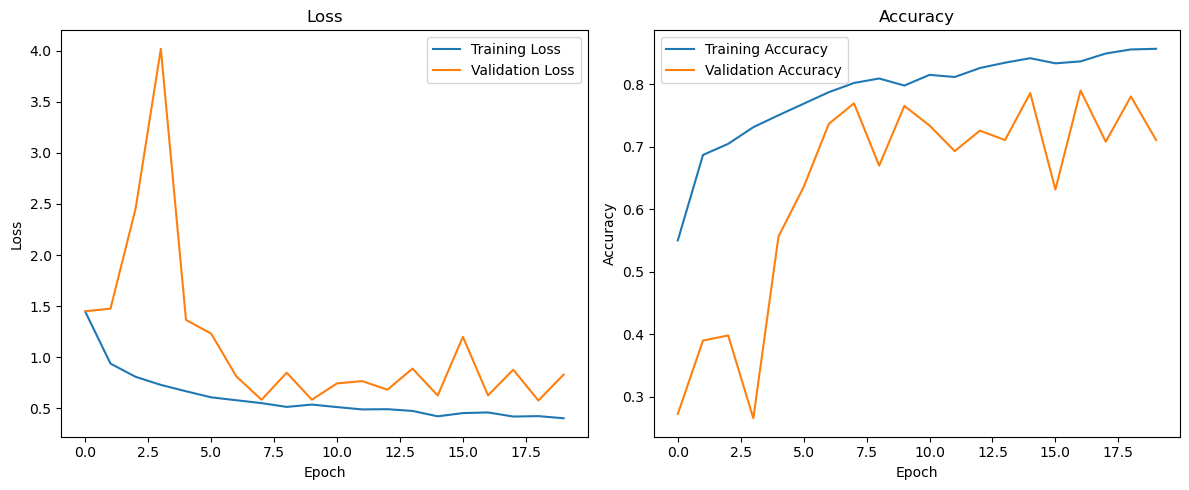

In [6]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_efficientnetb0.history['loss'], label='Training Loss')
plt.plot(history_efficientnetb0.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_efficientnetb0.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnetb0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
# Append results
results = []
def append_results(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    results.append((model_name, accuracy, precision, f1, recall))

In [8]:
# Evaluate and display results
y_pred = efficientnetb0_hybrid_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
append_results('efficientnetb0', y_val, y_pred_classes)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
results_df.set_index('Model', inplace=True)

23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


In [9]:
results_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                            
efficientnetb0  0.710778       0.774563       0.69733    0.710778

In [10]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, zero_division=0.0))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       361
           1       0.33      0.89      0.49        74
           2       0.75      0.28      0.41       200
           3       0.47      0.21      0.29        39
           4       0.56      0.71      0.63        59

    accuracy                           0.71       733
   macro avg       0.61      0.61      0.55       733
weighted avg       0.77      0.71      0.70       733



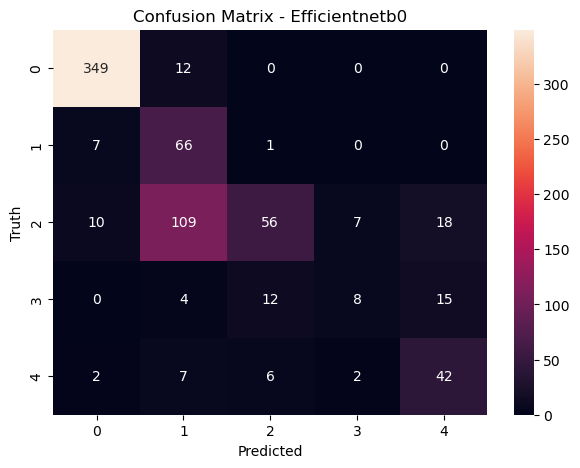

In [11]:
# Display confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - Efficientnetb0')
plt.show()

<h3 st<h3 style='color:red'>Analysis using Machine Learning models</h3>

In [13]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
# Define the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
# Append results
results = []
def append_results(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    results.append((model_name, accuracy, precision, f1, recall))

<h3 st<h3 style='color:purple'>SVM</h3>

In [15]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
svm_pred_val = svm_model.predict(X_val.reshape(X_val.shape[0], -1))
append_results('SVM', y_val, svm_pred_val)
# Create a DataFrame to store the results
temp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
temp_df.set_index('Model', inplace=True)
temp_df         

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                   
SVM    0.727149       0.687012      0.688344    0.727149

In [16]:
cm = confusion_matrix(y_val, svm_pred_val)
cm

array([[343,   5,  13,   0,   0],
       [  5,  33,  35,   1,   0],
       [ 21,  26, 153,   0,   0],
       [  3,   6,  26,   4,   0],
       [  4,  11,  44,   0,   0]], dtype=int64)

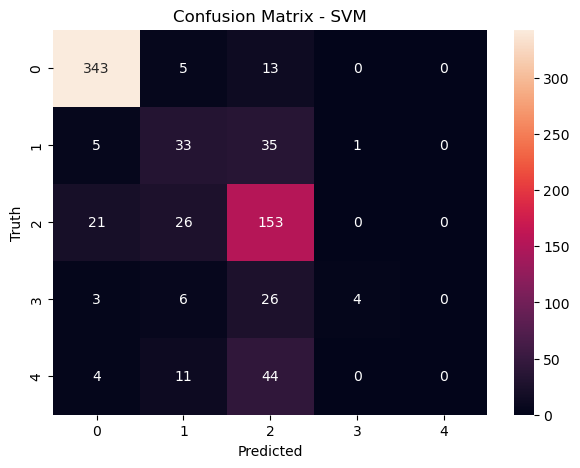

In [21]:
# Display confusion matrix for SVM
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM')
plt.show()

In [18]:
from sklearn.metrics import classification_report

In [20]:
# Classification Report
report = classification_report(y_val, svm_pred_val, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       361
           1       0.41      0.45      0.43        74
           2       0.56      0.77      0.65       200
           3       0.80      0.10      0.18        39
           4       1.00      0.00      0.00        59

    accuracy                           0.73       733
   macro avg       0.74      0.45      0.44       733
weighted avg       0.77      0.73      0.69       733



<h3 st<h3 style='color:purple'>Decision Trees</h3>

In [22]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on validation set
dt_pred_val = dt_model.predict(X_val.reshape(X_val.shape[0], -1))

# Append results
append_results('Decision Tree', y_val, dt_pred_val)

# Create a DataFrame to store the results
temp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
temp_df.set_index('Model', inplace=True)
print(temp_df)

# Confusion Matrix
cm = confusion_matrix(y_val, dt_pred_val)
print("Decision Tree Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_val, dt_pred_val, zero_division=1)
print("Decision Tree Classification Report:")
print(report)

               Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                           
SVM            0.727149       0.687012      0.688344    0.727149
Decision Tree  0.641201       0.648536      0.644488    0.641201
Decision Tree Confusion Matrix:
[[314  11  21   3  12]
 [  8  29  24   2  11]
 [ 23  21 111  16  29]
 [  2   7  19   4   7]
 [  3  10  29   5  12]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       361
           1       0.37      0.39      0.38        74
           2       0.54      0.56      0.55       200
           3       0.13      0.10      0.12        39
           4       0.17      0.20      0.18        59

    accuracy                           0.64       733
   macro avg       0.42      0.42      0.42       733
weighted avg       0.65      0.64      0.64       733



<h3 st<h3 style='color:purple'>Random Forest</h3>

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on validation set
rf_pred_val = rf_model.predict(X_val.reshape(X_val.shape[0], -1))

# Append results
append_results('Random Forest', y_val, rf_pred_val)

# Create a DataFrame to store the results
temp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
temp_df.set_index('Model', inplace=True)
print(temp_df)

# Confusion Matrix
cm = confusion_matrix(y_val, rf_pred_val)
print("Random Forest Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_val, rf_pred_val, zero_division=1)
print("Random Forest Classification Report:")
print(report)

               Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                           
SVM            0.727149       0.687012      0.688344    0.727149
Decision Tree  0.641201       0.648536      0.644488    0.641201
Random Forest  0.750341       0.721731      0.717802    0.750341
Random Forest Confusion Matrix:
[[350   4   7   0   0]
 [  7  36  30   1   0]
 [ 21  20 155   2   2]
 [  4   6  20   5   4]
 [  4  11  38   2   4]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       361
           1       0.47      0.49      0.48        74
           2       0.62      0.78      0.69       200
           3       0.50      0.13      0.20        39
           4       0.40      0.07      0.12        59

    accuracy                           0.75       733
   macro avg       0.58      0.49      0.48       733
weighted avg       0.72      0.75      0.72       733



<h3 st<h3 style='color:purple'>KNN</h3>

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on validation set
knn_pred_val = knn_model.predict(X_val.reshape(X_val.shape[0], -1))

# Append results
append_results('KNN', y_val, knn_pred_val)

# Create a DataFrame to store the results
temp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
temp_df.set_index('Model', inplace=True)
print(temp_df)

# Confusion Matrix
cm = confusion_matrix(y_val, knn_pred_val)
print("KNN Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_val, knn_pred_val, zero_division=1)
print("KNN Classification Report:")
print(report)


               Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                           
SVM            0.727149       0.687012      0.688344    0.727149
Decision Tree  0.641201       0.648536      0.644488    0.641201
Random Forest  0.750341       0.721731      0.717802    0.750341
KNN            0.724420       0.705345      0.697422    0.724420
KNN Confusion Matrix:
[[343   6  10   1   1]
 [  8  45  18   1   2]
 [ 26  37 135   1   1]
 [  6  13  13   2   5]
 [  3  16  34   0   6]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       361
           1       0.38      0.61      0.47        74
           2       0.64      0.68      0.66       200
           3       0.40      0.05      0.09        39
           4       0.40      0.10      0.16        59

    accuracy                           0.72       733
   macro avg       0.54      0.48      0.46       733
weighted av

<h3 st<h3 style='color:purple'>Multinomial Naive Bayes</h3>

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Train Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_flat, y_train)

# Predict on validation set
nb_pred_val = nb_model.predict(X_val_flat)

# Append results
append_results('Multinomial NB', y_val, nb_pred_val)

# Create a DataFrame to store the results
temp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Avg Precision', 'Avg F1-Score', 'Avg Recall'])
temp_df.set_index('Model', inplace=True)
print(temp_df)

# Confusion Matrix
cm = confusion_matrix(y_val, nb_pred_val)
print("Multinomial NB Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_val, nb_pred_val, zero_division=1)
print("Multinomial NB Classification Report:")
print(report)




                Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                            
SVM             0.727149       0.687012      0.688344    0.727149
Decision Tree   0.641201       0.648536      0.644488    0.641201
Random Forest   0.750341       0.721731      0.717802    0.750341
KNN             0.724420       0.705345      0.697422    0.724420
Multinomial NB  0.568895       0.680196      0.608058    0.568895
Multinomial NB Confusion Matrix:
[[276   9  12  55   9]
 [  4  45  10  14   1]
 [  7  46  78  44  25]
 [  4  14   8   9   4]
 [  1  17  24   8   9]]
Multinomial NB Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       361
           1       0.34      0.61      0.44        74
           2       0.59      0.39      0.47       200
           3       0.07      0.23      0.11        39
           4       0.19      0.15      0.17        59

    accuracy             

In [28]:
temp_df

Accuracy  Avg Precision  Avg F1-Score  Avg Recall
Model                                                            
SVM             0.727149       0.687012      0.688344    0.727149
Decision Tree   0.641201       0.648536      0.644488    0.641201
Random Forest   0.750341       0.721731      0.717802    0.750341
KNN             0.724420       0.705345      0.697422    0.724420
Multinomial NB  0.568895       0.680196      0.608058    0.568895

# Model Performance Summary

## Deep Learning Models with Transfer Learning

| Model            | Validation Accuracy |
|------------------|---------------------|
| **DenseNet121**  | **79%**             |
| **VGG16**        | **76%**             |
| **InceptionV3**  | **75%**             |
| **ResNet50**     | **71%**             |
| **EfficientNetB0** | **71%** (reached up to 78% in a few epochs) |

---

## Machine Learning Algorithms

| Algorithm        | Validation Accuracy |
|------------------|---------------------|
| **Random Forest**| **75%**             |
| **SVM**          | **73%**             |
| **KNN**          | **72%**             |
| **Decision Trees**| **64%**             |
| **MultinomialNB**| **57%**             |
